In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path
from itertools import cycle

%matplotlib inline

In [2]:
d = pd.read_csv('../data/lasso-KA+TN-bulletin.csv')

In [3]:
d.rename(columns={
    'Women whose Body Mass Index (BMI) is below normal (BMI < 18.5 kg/m2)14 (%)' : 'Women whose Body Mass Index (BMI) is below normal (%)',
    'Women who are overweight or obese (BMI ≥ 25.0 kg/m2)14 (%)' : 'Women who are overweight or obese (%)',
    'All women age 15-49 years who are anaemic (%)' : 'All women who are anaemic (%)',
    'Women Blood sugar level - high (>140 mg/dl) (%)':'Women Blood sugar level - high (%)',
    'Women Very high (Systolic ≥180 mm of Hg and/or Diastolic ≥110 mm of Hg) (%)' : 'Women Very high blood pressure (%)',
    'Men whose Body Mass Index (BMI) is below normal (BMI < 18.5 kg/m2) (%)' : 'Men whose Body Mass Index (BMI) is below normal (%)',
    'Men who are overweight or obese (BMI ≥ 25.0 kg/m2) (%)' : 'Men who are overweight or obese (%)',
    'Men age 15-49 years who are anaemic (<13.0 g/dl) (%)' : 'Men who are anaemic (%)',
    'Men Blood sugar level - high (>140 mg/dl) (%)' : 'Men Blood sugar level - high (%)',
    'Men Very high (Systolic ≥180 mm of Hg and/or Diastolic ≥110 mm of Hg) (%)' : 'Men Very high blood pressure (%)'
}, inplace=True)

d = d[d['District'] != 'Erode.pdf']
d.head()

,District,Sex Ratio (females every 1000 males),Total_Positives,total_deaths,male_deaths,female_deaths,Male cases (in data),Female cases (in data),Estimated Male cases,Estimated Female Cases,...,Women whose Body Mass Index (BMI) is below normal (%),Men whose Body Mass Index (BMI) is below normal (%),Women who are overweight or obese (%),Men who are overweight or obese (%),All women who are anaemic (%),Men who are anaemic (%),Women Blood sugar level - high (%),Men Blood sugar level - high (%),Women Very high blood pressure (%),Men Very high blood pressure (%)
0,Bangalore,898,94106,299.0,196,103,14096,8401,39172.031970,23345.930800,...,14.0,8.7,32.0,26.1,39.6,20.5,8.3,10.9,0.4,0.7
1,Bellary,952,15180,31.0,23,8,1396,634,6935.034971,3149.578920,...,23.6,18.4,18.9,20.9,49.9,20.0,4.0,6.5,0.6,2.5
2,Mysore,1008,11489,55.0,37,18,822,445,4951.820981,2680.730336,...,19.1,10.2,29.3,20.2,45.6,9.1,5.9,7.3,0.5,1.2
3,Dakshina Kannada,1032,9296,43.0,32,11,1686,899,4027.918193,2147.745228,...,25.6,21.8,26.0,20.4,45.4,15.7,5.5,9.0,1.4,1.0
4,Gulbarga,989,9265,27.0,16,11,1219,774,3764.690985,2390.378033,...,22.5,20.5,14.8,18.8,43.1,14.9,3.6,8.5,0.4,0.4


In [4]:
def make_lasso_plots(df, y_col_name, x_col_names, legend_names, title_name):
    y = df[y_col_name]
    x = df[x_col_names]
    
    x = x.to_numpy()
    y = y.to_numpy()

    y = y.reshape(-1,1)

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    scaler = StandardScaler()
    y = scaler.fit_transform(y)
    
    eps = 1e-4
    alphas_lasso, coefslasso, _  = lasso_path(x, y, eps=eps, fit_intercept=False)
    coefs_lasso = coefslasso.reshape(5,100)
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    
    plt.figure(figsize=(20,15))
    plt.figure(1)
    colors = cycle(['#008080','#ffa500','#00ff00','#0000ff','#ff1493'])
    neg_log_alphas_lasso = np.log10(alphas_lasso)
    for coef_l,c,n in zip(coefs_lasso,colors,legend_names):
        plt.plot(neg_log_alphas_lasso, coef_l,c=c,label=n)

    plt.legend(loc='upper right', fontsize = 14)
    plt.xlabel(r'$log_{10}λ$', fontsize = 20)
    plt.ylabel('Coefficients', fontsize = 20)
    plt.title(title_name)
    plt.axis('tight')
    
    max_alpha = 0
    max_r2 = 0
    for alphas in alphas_lasso:
        clf = linear_model.Lasso(alpha=alphas)
        clf.fit(x,y)
        r2 = clf.score(x, y, sample_weight=None)
        if(r2 > max_r2):
            max_r2 = r2
            max_alpha = alphas
           
    print('max R2 :',max_r2)
    print('log(alpha corresponding to max R2) :',np.log10(max_alpha))
    print('alpha corresponding to max R2 :', max_alpha)
    return max_alpha

In [5]:
def make_residual_plots(alpha, y_col_name, x_col_names, label_names):
    y = df[y_col_name]
    x = df[x_col_names]
    
    x = x.to_numpy()
    y = y.to_numpy()

    y = y.reshape(-1,1)

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    scaler = StandardScaler()
    y = scaler.fit_transform(y)
    
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(x,y)
    
    y_hat = clf.predict(x)
    residual = y_hat - y.reshape(y_hat.shape)
    
    for i in range(len(x_col_names)):
        plt.figure(figsize = (15,8))
        plt.scatter(x[:,i],residual,color='red', label = 'Data points')
        plt.axhline(y=0, linestyle='--')
        plt.ylabel("Residuals")
        plt.xlabel(label_names[i])

max R2 : 0.15293206514430935
log(alpha corresponding to max R2) : -4.505872538293058
alpha corresponding to max R2 : 3.1198050857859206e-05


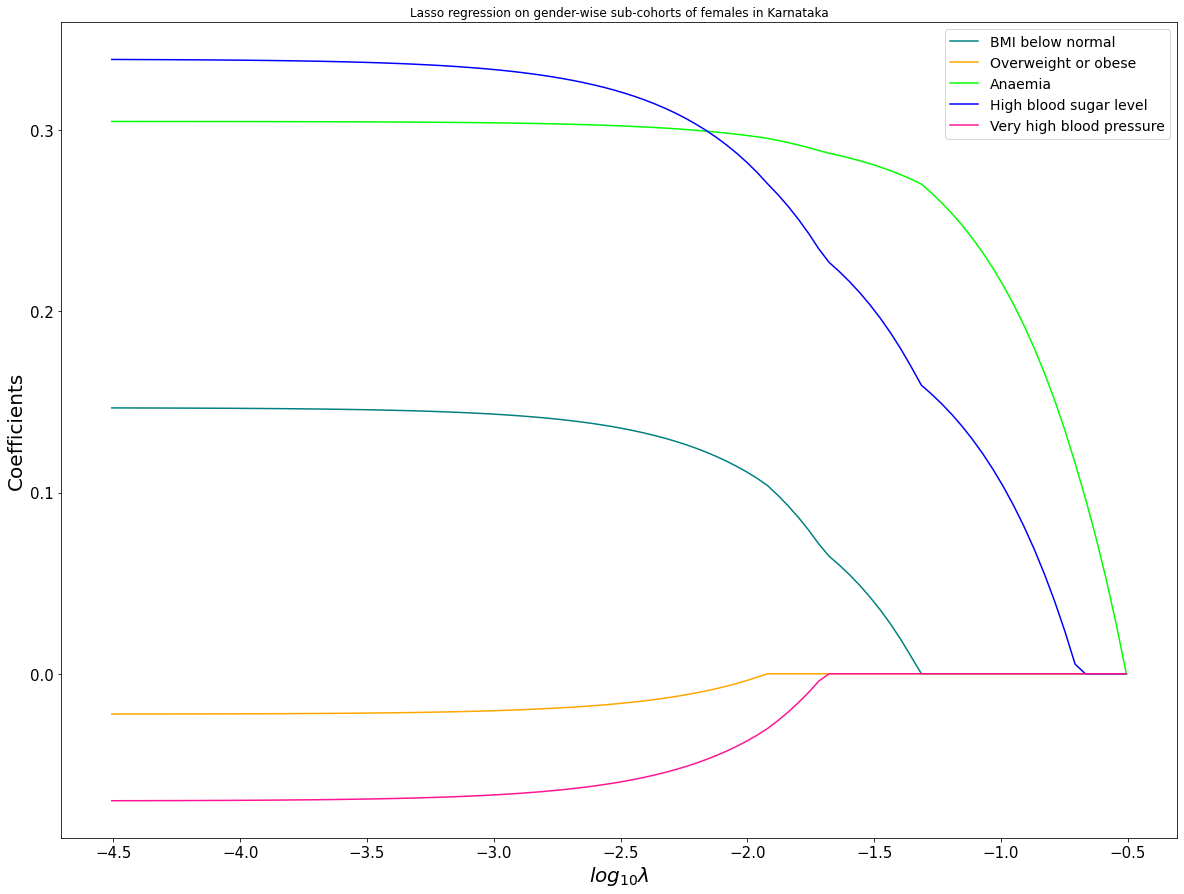

In [6]:
df = d[d['State'] == 'KA']
df = df[df['female_deaths'] >= 5]

max_alpha = make_lasso_plots(df, 'Female Mortality', 
                ['Women whose Body Mass Index (BMI) is below normal (%)',
                 'Women who are overweight or obese (%)',
                 'All women who are anaemic (%)',
                 'Women Blood sugar level - high (%)',
                 'Women Very high blood pressure (%)'], 
                ['BMI below normal',
                 'Overweight or obese',
                 'Anaemia',
                 'High blood sugar level',
                 'Very high blood pressure'],
                'Lasso regression on gender-wise sub-cohorts of females in Karnataka')

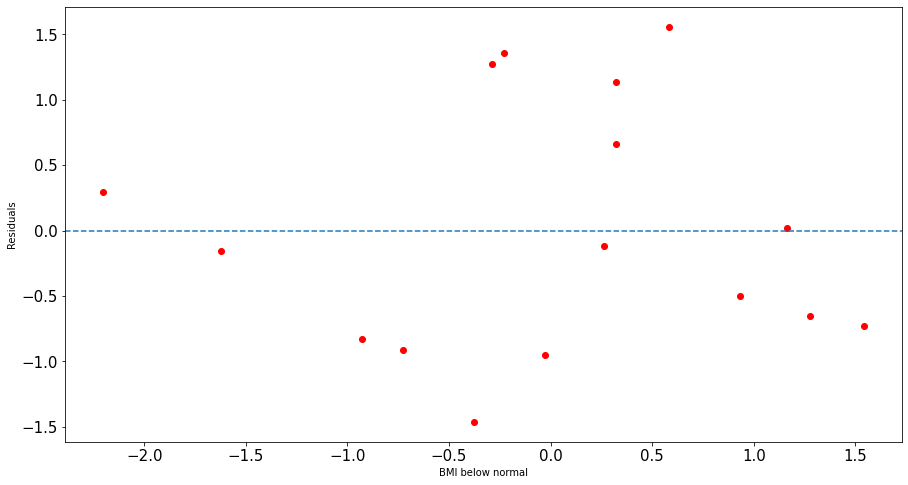

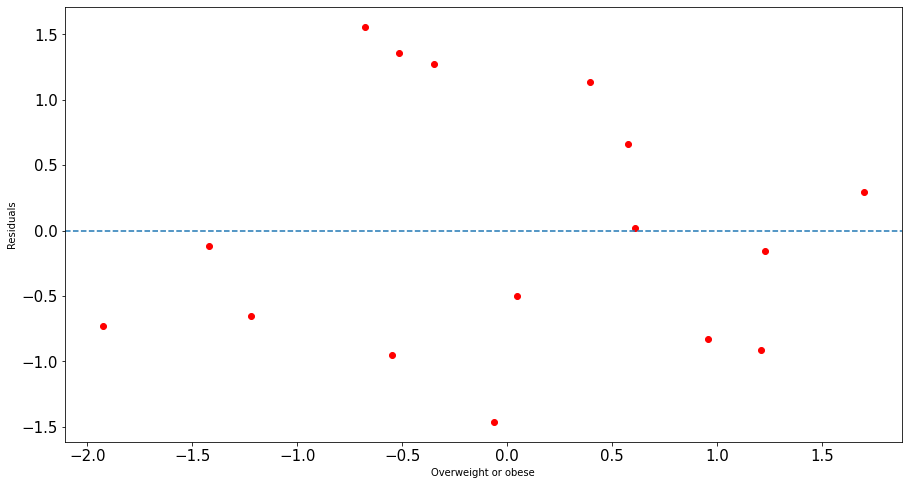

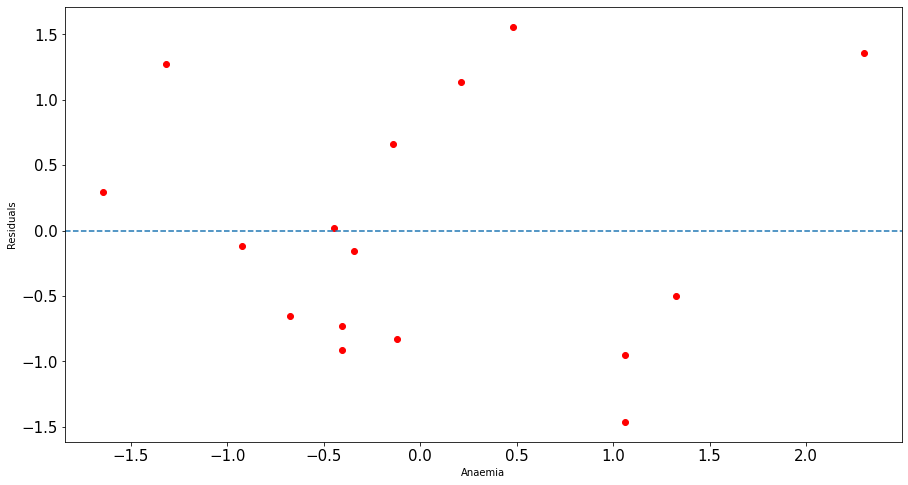

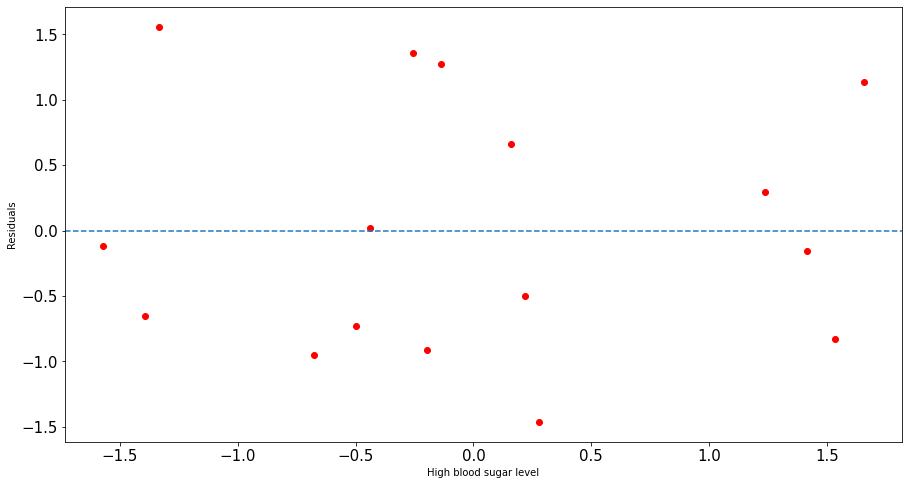

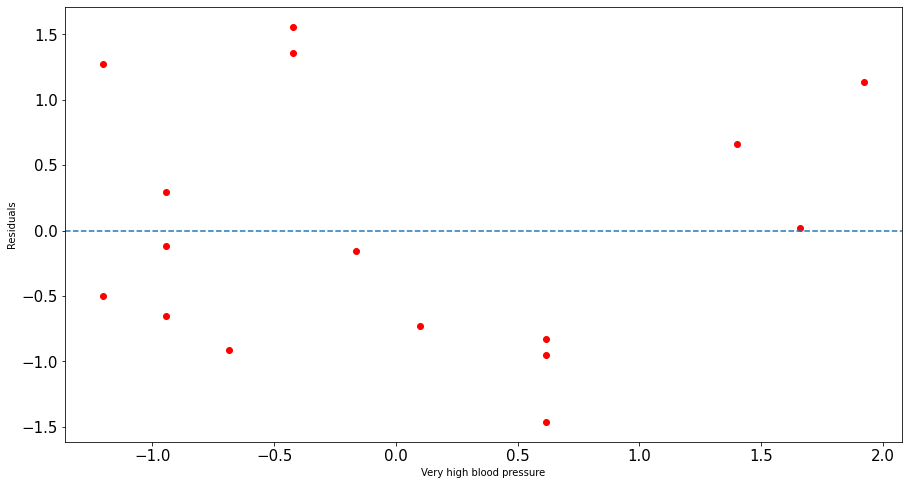

In [7]:
make_residual_plots(max_alpha, 'Female Mortality', 
                ['Women whose Body Mass Index (BMI) is below normal (%)',
                 'Women who are overweight or obese (%)',
                 'All women who are anaemic (%)',
                 'Women Blood sugar level - high (%)',
                 'Women Very high blood pressure (%)'], 
                ['BMI below normal',
                 'Overweight or obese',
                 'Anaemia',
                 'High blood sugar level',
                 'Very high blood pressure'])

max R2 : 0.1917463551418378
log(alpha corresponding to max R2) : -4.5712606470273
alpha corresponding to max R2 : 2.6837332876000663e-05


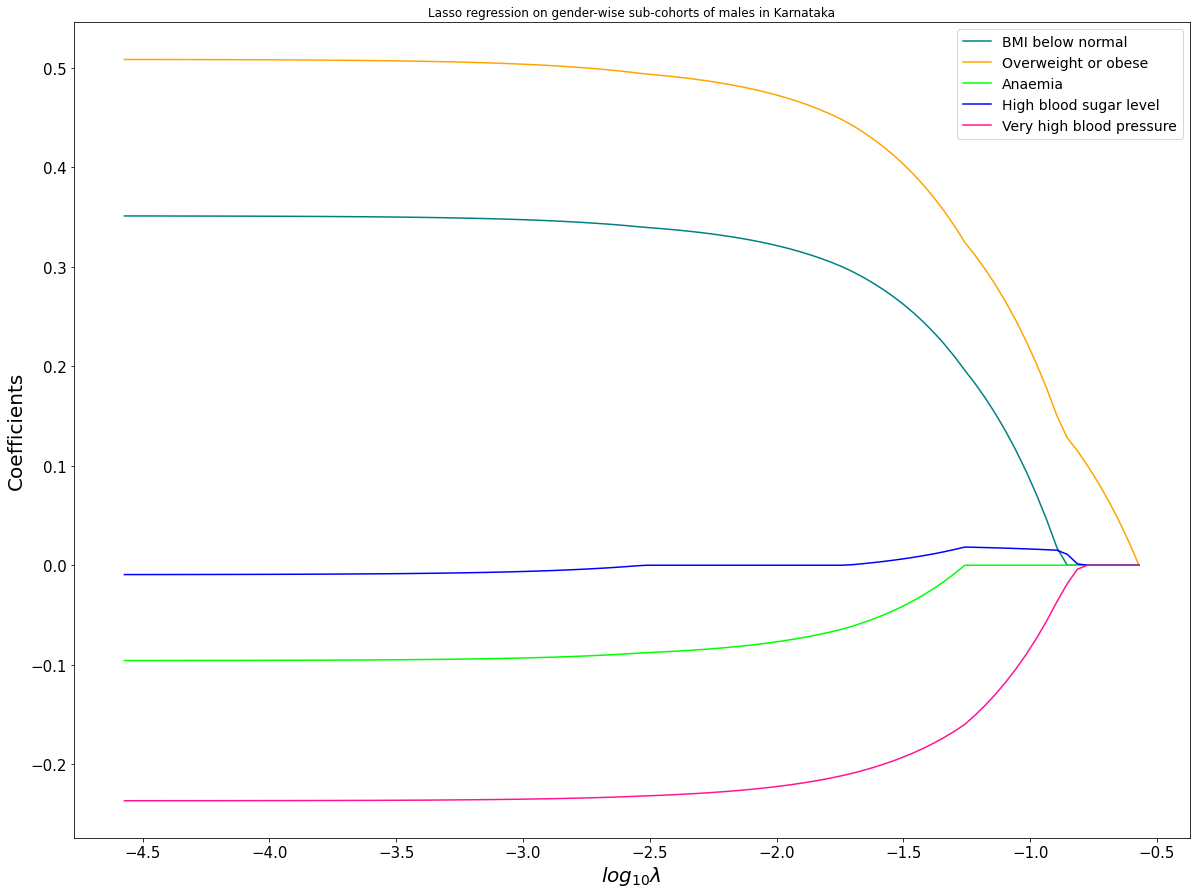

In [8]:
df = d[d['State'] == 'KA']
df = df[df['male_deaths'] >= 5]
max_alpha = make_lasso_plots(df, 'Male Mortality', 
                ['Men whose Body Mass Index (BMI) is below normal (%)',
                'Men who are overweight or obese (%)',
                'Men who are anaemic (%)',
                'Men Blood sugar level - high (%)',
                'Men Very high blood pressure (%)'], 
                ['BMI below normal',
                 'Overweight or obese',
                 'Anaemia',
                 'High blood sugar level',
                 'Very high blood pressure'],
                'Lasso regression on gender-wise sub-cohorts of males in Karnataka')

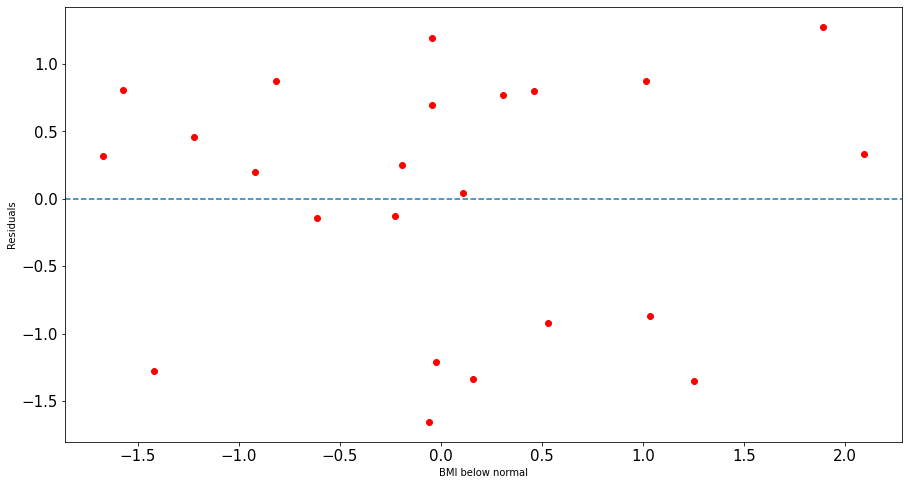

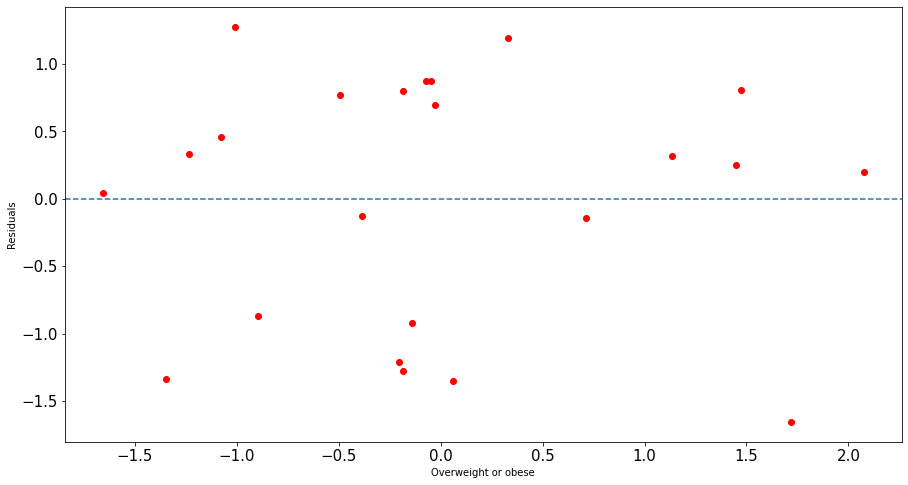

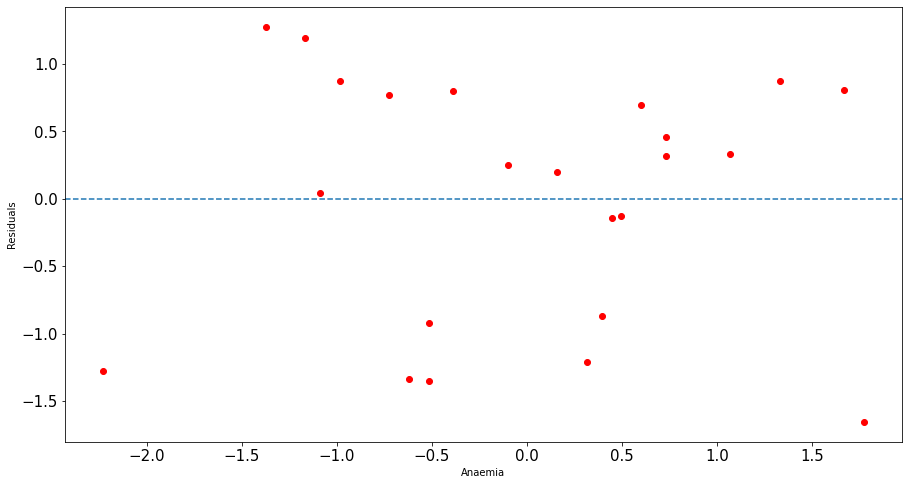

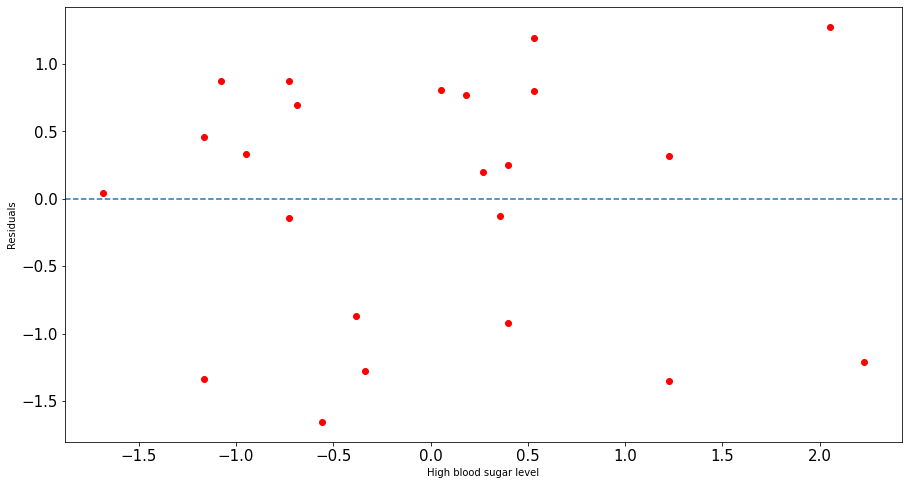

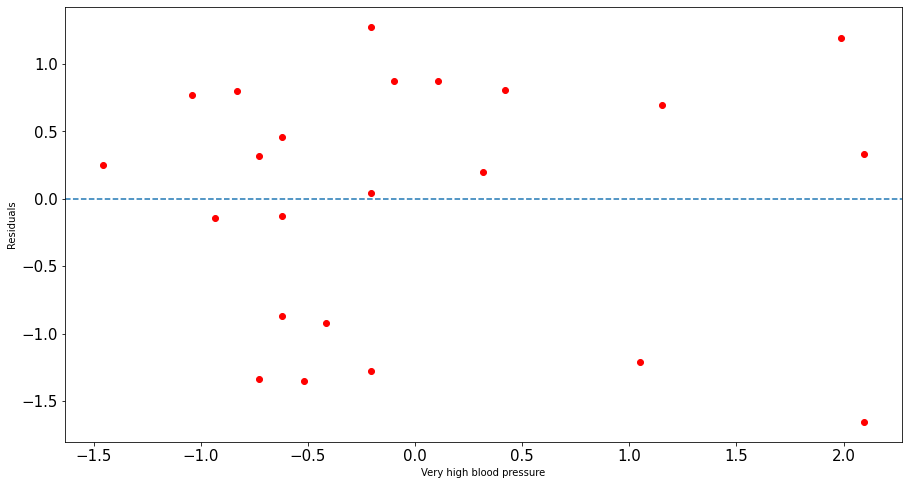

In [9]:
make_residual_plots(max_alpha, 'Male Mortality', 
                ['Men whose Body Mass Index (BMI) is below normal (%)',
                'Men who are overweight or obese (%)',
                'Men who are anaemic (%)',
                'Men Blood sugar level - high (%)',
                'Men Very high blood pressure (%)'], 
                ['BMI below normal',
                 'Overweight or obese',
                 'Anaemia',
                 'High blood sugar level',
                 'Very high blood pressure'])